In [1]:
import sys
venvpath = '/afs/desy.de/user/l/lorenzg/pyhfenv/lib/python3.8/site-packages'
venvpath = sys.path.append(venvpath)
if venvpath not in sys.path:
    sys.path.append(venvpath)

import json
import yaml
import numpy as np
import scipy as sp

import warnings
import pyhf
from os import environ
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('mybelle2')

print(np.__version__, sp.__version__, pyhf.__version__)

1.24.1 1.10.0 0.5.4


In [2]:
anafile = 'hepdata/postfit_yields_Y4S.yaml'
with open(anafile) as f:
    hepy4s = yaml.safe_load(f)
    
anafile = 'hepdata/postfit_yields_offres.yaml'
with open(anafile) as f:
    hepoff = yaml.safe_load(f)

In [3]:
def reorder(l):
    n = len(l)
    order = np.concatenate((np.arange(3, n), np.arange(3)))
    return  np.array([l[i] for i in order])

def clean(name):
    rm = ['Number', 'of', 'events', 'backgrounds', 'backgrounda', 'from', 'Observed','rightarrow', '^', '\\', '$', ' ']
    for r in rm:
        name = name.replace(r, '')
    return name

def combinedicts(d1, d2):
    d = {}
    for k1 in d1.keys():
        if k1 in d2:
            d[k1] = np.concatenate((d1[k1], d2[k1]))
        else:
            d[k1] = np.concatenate((d1[k1], np.zeros(len(d1[k1]))))
    for k2 in d2.keys():
        if k2 not in d:
            d[k2] = np.concatenate((d2[k2], np.zeros(len(d2[k2]))))
    return d

off = {clean(h['header']['name']):reorder([v['value'] for v in h['values']])
 for h in hepoff['dependent_variables']}
y4s = {clean(h['header']['name']):reorder([v['value'] for v in h['values']])
 for h in hepy4s['dependent_variables']}

hepdata = combinedicts(y4s, off)


## FITTING

In [4]:
def get_mc_counts(pars,return_by_sample=False):
    #pars = pyhf.tensorlib.astensor(pars)
    #deltas, factors = pdf._modifications(pars)
    #allsum = pyhf.tensorlib.concatenate(deltas + [pdf.nominal_rates])
    #nom_plus_delta = pyhf.tensorlib.sum(allsum, axis=0)
    #nom_plus_delta = pyhf.tensorlib.reshape(
    #    nom_plus_delta, (1,) + pyhf.tensorlib.shape(nom_plus_delta)
    #)
    #allfac = pyhf.tensorlib.concatenate(factors + [nom_plus_delta])
    ##print(allfac)
    #return pyhf.tensorlib.product(allfac, axis=0)
    pars = pyhf.tensorlib.astensor(pars)
    deltas, factors = pdf._modifications(pars)

    allsum = pyhf.tensorlib.concatenate(deltas + [pdf.nominal_rates])

    nom_plus_delta = pyhf.tensorlib.sum(allsum, axis=0)
    nom_plus_delta = pyhf.tensorlib.reshape(
        nom_plus_delta, (1,) + pyhf.tensorlib.shape(nom_plus_delta)
    )

    allfac = pyhf.tensorlib.concatenate(factors + [nom_plus_delta])

    newbysample = pyhf.tensorlib.product(allfac, axis=0)
    if return_by_sample:
        batch_first = pyhf.tensorlib.einsum('ij...->ji...', newbysample)
        if pdf.batch_size is None:
            return batch_first[0]
        return batch_first

    newresults = pyhf.tensorlib.sum(newbysample, axis=0)
    if pdf.batch_size is None:
        return newresults[0]
    return newresults

In [5]:
JSON = environ['BELLE2_ANALYSIS_DIR']+'/plotting/json/'
version_of_json = 'pyhf_publication_B_K_nunu'

json_workspace = json.load(open(f'{JSON}/'+version_of_json+'.json')) 
del json_workspace['content'] #binning needs to be deleted from json file so that validation below works

#Load pdf from json file
pdf = pyhf.Model({"channels":json_workspace["channels"]})

#Load data from json file
myjson=json_workspace #holder for plotting
observations = []
for i in range(len(myjson['observations'])):
    observations += myjson['observations'][i]['data']
data = pyhf.tensorlib.astensor(observations + pdf.config.auxdata)

pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
#pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True))

pdf.config.par_map['mu']['paramset'].suggested_bounds=[(-1000,1000)]

init_pars = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

#scipy
best_fit = pyhf.infer.mle.fit(data, pdf, init_pars, par_bounds)
#miuit
#best_fit = pyhf.infer.mle.fit(data, pdf, init_pars, par_bounds, maxiter=int(1e9), tolerance=10e-10)


#yields = {k: v for k, v in zip(pdf.config.samples,
#    pdf.main_model.expected_data(best_fit, return_by_sample=True))}
yields = {k: v for k, v in zip(pdf.config.samples,
    get_mc_counts(best_fit, return_by_sample=True))}
yields['obs'] = observations

/nfs/dust/belle1/user/lorenzg/pyhf_and_b2luigi_new/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py:312: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)


In [6]:
best_fit

array([ 1.00000364e+00,  9.99999797e-01,  1.00001597e+00,  1.00001868e+00,
        9.99985530e-01,  9.99966194e-01,  9.99988034e-01,  9.99973694e-01,
        1.00010785e+00,  4.20829503e+00,  6.23642204e-02,  3.12721470e-02,
       -2.79919076e-02,  5.50479097e-04,  2.89118658e-03,  3.06512524e-03,
        1.26134524e-01,  1.67990155e-01,  6.79872927e-01,  1.00187694e+00,
        9.99946960e-01,  1.01403680e+00,  1.01862773e+00,  9.89234001e-01,
        9.82833298e-01,  1.00000054e+00,  1.00000102e+00,  1.00000086e+00,
        7.02555648e-02,  1.00233442e+00,  9.99869565e-01,  1.01080103e+00,
        1.01149260e+00,  9.87893272e-01,  9.76290961e-01,  9.91617764e-01,
        9.88827042e-01,  1.05943918e+00,  4.36250992e-02,  1.00300276e+00,
        9.99830719e-01,  1.01366297e+00,  1.01001566e+00,  9.88377789e-01,
        9.73045439e-01,  9.89406527e-01,  9.46501429e-01,  1.07499818e+00,
        7.55997463e-01,  1.00314087e+00,  9.99823769e-01,  1.01540142e+00,
        1.01379327e+00,  

## DIFFERENCES

In [7]:
yieldkeys = ['obs', 'signal', 'charged', 'mixed', 'ccbar', 'ddbar', 'ssbar', 'taupair', 'uubar',]
hepkeys = ['data', 'signalB+K+nubarnu', 'chargedB', 'neutralB', 'cbarc', 'dbard', 'sbars', 'tautau', 'ubaru']

diffdict = {}
for yk, hk in zip(yieldkeys, hepkeys):
    print(yk)
    diff = yields[yk]-hepdata[hk]
    #where = np.where(np.array(yields[yk]) != 0, True, False)
    #np.divide((yields[yk]-hepdata[hk]), hepdata[hk], out=diff, where=where)
    print(diff)
    diffdict[yk] = diff
    if np.where(diff>1e-1)[0].size > 0:
        warnings.warn("Differences found.")

obs
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
signal
[-0.00114964 -0.00091104 -0.00025616 -0.00106025 -0.00125593 -0.0004018
 -0.00031012 -0.00059281 -0.00024733 -0.00106281 -0.00071042 -0.00018083
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
charged
[0.0732588  0.03527827 0.00586564 0.0423158  0.02729837 0.00690126
 0.00501718 0.00711407 0.00334382 0.09837004 0.03979882 0.00513403
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
mixed
[-0.01279189 -0.00541556 -0.00089056 -0.00838559 -0.00528063 -0.0008653
 -0.00118519 -0.00124928 -0.00030545 -0.01655435 -0.00714379 -0.00087357
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
ccbar
[-5.50762814e-03 -7.13416679e-04  2.33424473e-03 -1.76965746e-03
 

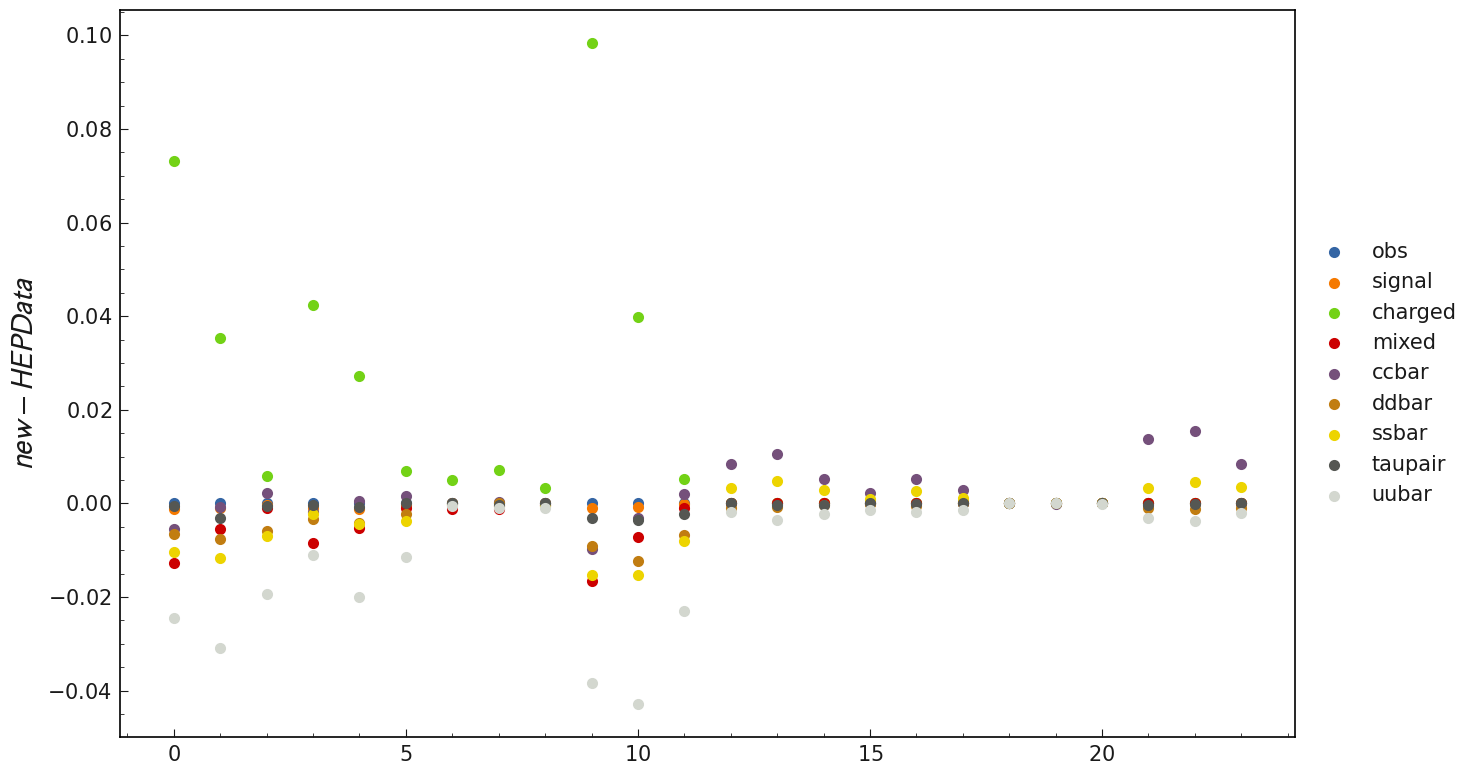

In [8]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(111)
for k,v in diffdict.items():
    plt.scatter(np.arange(len(v)), v, label=k)
#plt.xticks(rotation = 90, fontsize=10) # Rotates X-Axis Ticks by 45-degrees
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylabel(r'$new-HEPData$')

#plt.savefig('../../../../results/fit/binningcompare17.pdf', bbox_inches='tight')
plt.show()

In [9]:
json_workspace = json.load(open(f'{JSON}/'+version_of_json+'.json')) 
# json_workspace = json.load(open(f'/nfs/dust/belle1/user/lorenzg/publik/results/weights/pyhfJSON/pyhf_weight_cVL=0.0e+00_cSL=0.0e+00_cTL=0.0e+00_B_K_nunu.json')) 
del json_workspace['content'] #binning needs to be deleted from json file so that validation below works
pubjson = json_workspace
# del pubjson["channels"][2:]
# for i in range(len(pubjson["channels"])):
#     del pubjson["channels"][i]["samples"][2:4]
#     for j in range(len(pubjson["channels"][i]["samples"])):
#         del pubjson["channels"][i]["samples"][j]["modifiers"][4:]
# del pubjson["observations"][2:]

for ch in pubjson["channels"]:
    for sam in ch["samples"]:
        print(sam["name"])

signal
ddbar
uubar
ssbar
ccbar
charged
mixed
taupair
signal
ddbar
uubar
ssbar
ccbar
charged
mixed
taupair
ddbar
uubar
ssbar
ccbar
taupair
ddbar
uubar
ssbar
ccbar
taupair


In [10]:
pdf = pyhf.Model({"channels":pubjson["channels"]})

observations = []
for i in range(len(pubjson['observations'])):
    observations += pubjson['observations'][i]['data']
data = pyhf.tensorlib.astensor(observations + pdf.config.auxdata)

pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
#pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True))

pdf.config.par_map['mu']['paramset'].suggested_bounds=[(-1000,1000)]

init_pars = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(data, pdf, init_pars, par_bounds, 
                                                         return_fitted_val=True, return_result_obj=True
                                                        )
twice_nll

array(-53.34954517)

In [11]:
best_fit_dict = {k: best_fit[v["slice"]].tolist() for k, v in pdf.config.par_map.items()}
init_fit_dict = {k: init_pars[v["slice"]] for k, v in pdf.config.par_map.items()}

print(init_fit_dict["mu_bkg_ccbar"], best_fit_dict["mu_bkg_ccbar"])
pars = best_fit.copy()
pars[pdf.config.par_map["mu_bkg_ssbar"]["slice"]] = 0
pars[pdf.config.par_map["mu_bkg_ccbar"]["slice"]] = 0.5

pyhf.infer.mle.twice_nll(pars, data, pdf)

[0.0] [0.8564773172646776]


array([-27.8731844])

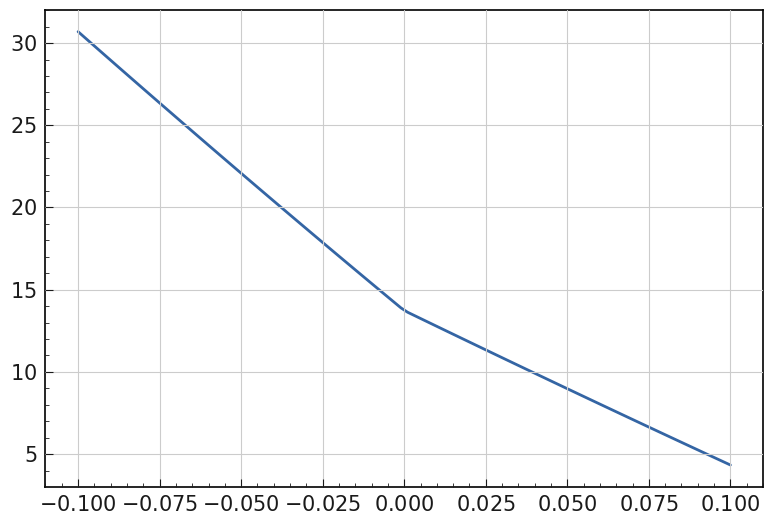

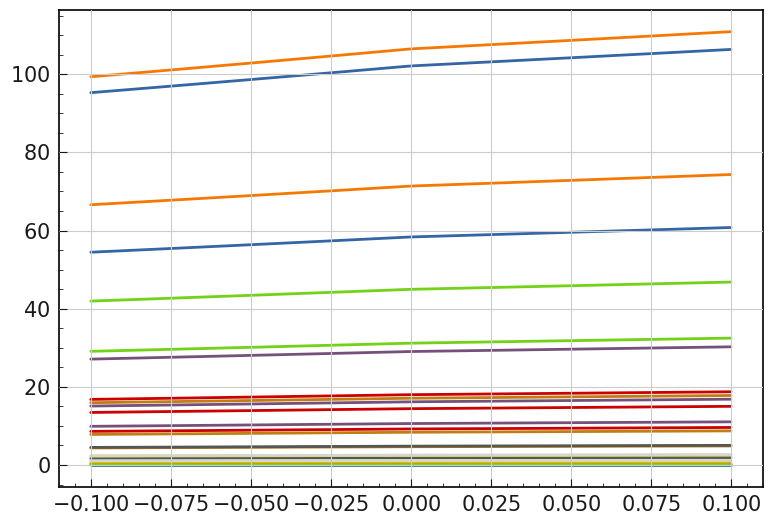

In [12]:
scan = np.linspace(-0.1, 0.1, 100)
nll = []
bin =[]
for i in scan:
    pars = best_fit.copy()
    pars[pdf.config.par_map["mu_bkg_ccbar"]["slice"]] = i
    pars[pdf.config.par_map["mu_bkg_ssbar"]["slice"]] = 0
    nll.append(pyhf.infer.mle.twice_nll(pars, data, pdf))
    yields = {k: v for k, v in zip(pdf.config.samples,
                pdf.main_model.expected_data(pars, return_by_sample=True))}  
    bin.append(yields["ccbar"])
    
plt.plot(scan, nll)
plt.grid()
plt.show()
plt.plot(scan, bin)
plt.grid()
#plt.ylim((-2e-6,2e-6))
plt.show()

In [13]:
for k, v in pdf.config.par_map.items():
    pars = init_pars.copy()
    pars[v["slice"]] = best_fit[v["slice"]]
    print(k, init_pars[v["slice"]], pyhf.infer.mle.twice_nll(pars, data, pdf))

uncorr_siguncrt_signal_zoomSR_Y4S [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [44.18691224]
mu [1.0] [22.63705243]
corr_pid_c1 [0.0] [44.20999929]
corr_pid_c2 [0.0] [44.17434414]
corr_pid_c3 [0.0] [44.11839947]
corr_ff_c1 [0.0] [44.18683034]
corr_ff_c2 [0.0] [44.18607608]
corr_ff_c3 [0.0] [44.18606354]
corr_trackingEff_c [0.0] [44.33482663]
corr_neutralGamma_c [0.0] [43.90430131]
corr_neutralUnmatched_c [0.0] [37.09383999]
uncorr_bkguncrt_ddbar_zoomSR_Y4S [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [44.15676632]
mu_bkg_ddbar [0.0] [43.62650243]
uncorr_bkguncrt_uubar_zoomSR_Y4S [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [44.11384805]
mu_bkg_uubar [0.0] [42.95661157]
uncorr_bkguncrt_ssbar_zoomSR_Y4S [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [43.99215956]
mu_bkg_ssbar [0.0] [-0.47449796]
uncorr_bkguncrt_ccbar_zoomSR_Y4S [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [43.9691485]
mu_bkg_ccbar [0.0] [-31.3695257]
uncorr_bkguncrt_charged_zoomSR_Y4S [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [14]:
yields = {k: v for k, v in zip(pdf.config.samples,
    pdf.main_model.expected_data(best_fit, return_by_sample=True))}    
yields

{'ccbar': array([8.25836992e+01, 1.01007278e+02, 4.41230216e+01, 2.54639006e+01,
        4.10945101e+01, 2.41764218e+01, 9.05808908e-01, 2.55744391e+00,
        1.64428230e+00, 1.44508299e+02, 1.50682397e+02, 6.36155297e+01,
        1.30543678e+01, 1.50129801e+01, 6.62057808e+00, 3.45259520e+00,
        6.82935497e+00, 3.58132276e+00, 1.41520834e-06, 3.58673946e-01,
        1.22538522e-01, 2.04004666e+01, 2.28813364e+01, 1.18600735e+01]),
 'charged': array([ 93.9315517 ,  44.27454017,   6.80024721,  57.9218285 ,
         37.48031917,   8.12277635,   7.57828105,  10.74982197,
          3.78264004, 123.17233604,  47.99022102,   6.21364405,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ]),
 'ddbar': array([3.58612456e+00, 4.02419548e+00, 3.24908476e+00, 1.77406967e+00,
        2.12183221e+00, 1.24047982e+00, 1.02889635e-06, 1.02889684e-06,
       